# Derivaciones UGCC

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import scipy 
from scipy import stats
import datetime as dt
from datetime import timedelta  
import urllib.request  # importar archivos web
from lifelines import NelsonAalenFitter # modelamiento survival

# para tratar de poner espanol
from datetime import date, datetime, time
from babel.dates import format_date, format_datetime, format_time, format_timedelta, Locale
import locale                                    # para tratar de poner espanol
# locale.setlocale(locale.LC_ALL,'es_ES.UTF-8')  

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [2]:
BD = pd.read_excel('./BDs/Derivaciones/Derivaciones historicas 20200805.xlsx'
                   , dayfirst=True)

# Algunos preparativos generales

In [3]:
BD.columns

Index(['id', 'Pestaña', 'Id Madre', 'Servicio Salud', 'Origen', 'Tipo Destino',
       'Destino', 'Tipo cama', 'Fecha creación', 'Hora creación',
       'Fecha derivación exitosa', 'Hora derivación exitosa', 'Especialidad',
       'Nombre Paciente', 'rut paciente', 'Nuevo RUT Paciente', 'Edad días',
       'Edad meses', 'Edad años', 'Diagnóstico', 'Responsable', 'Rol',
       'Riesgo', 'cambio riesgo', 'Convenio', 'Paciente crónico', 'GES',
       'Dias de Estada', 'Alerta dias de estada', 'Tramo Fonasa',
       'Asistencia Ventricular', 'Tipo compra', 'ECMO', 'Id anterior',
       'Re-derivaciones', 'ID-RNacidos', 'Contingencia', 'Cuenta GRD'],
      dtype='object')

In [4]:
BD = BD.drop(columns='Alerta dias de estada')

In [5]:
mapa_categorias = dict(
  {'PRIVADO'	: 'Privado',
   'PÚBLICO'	: 'Público'
    })

BD['Tipo Destino'] = BD['Tipo Destino'].replace(mapa_categorias)

In [6]:
BD['Fecha creación'] = BD['Hora creación'].astype('str') + ' ' + BD['Fecha creación'].astype('str')
BD['Fecha derivación exitosa'] = BD['Hora derivación exitosa'].astype('str') + ' ' + BD['Fecha derivación exitosa'].astype('str')

In [7]:
BD = BD.drop(columns= ['Hora creación', 'Hora derivación exitosa'])

In [8]:
# lo que es fecha lo dejo como tal para después poder analizar
# fechas = [s for s in BD.columns if "Fecha" in s]

fechas = 'cambio riesgo', 'Fecha creación', 'Fecha derivación exitosa'
for date in fechas:
    BD[date] = pd.to_datetime(BD[date],
                              dayfirst=True,
                             errors='coerce')

# Algunas definiciones

In [9]:
# temporalidad de los casos
# Dejo los casos nulos y erroneos y 'Buscando o asignando destino', 
# Me quedo solo con: 'Historicas' y 'Exitosa'

caso_valido = (BD.Pestaña == 'Histórica') | (BD.Pestaña == 'Exitosa')
# BD.loc[caso_valido, 'Subset_validos'] = 'Validos'

print('Casos válidos')
BD.Pestaña.value_counts()
caso_valido.value_counts()

# Me quedo sólo con las derivaciones tipo UPC
camaUPC = (BD['Tipo cama'] == 'UCI') | (BD['Tipo cama'] == 'UTI')
# BD.loc[camaUPC, 'Subset_UPC'] = 'UPC'

print('\n')
print('Cama UPC')
BD.loc[caso_valido]['Tipo cama'].value_counts() #sólo los válidos
camaUPC.value_counts()

Casos válidos


Histórica                       4807
Nula                            1872
Errónea                          300
Exitosa                           46
Buscando o asignando destino       2
Name: Pestaña, dtype: int64

True     4853
False    2174
Name: Pestaña, dtype: int64



Cama UPC


UCI           2446
UTI           1860
BASICA         505
AGUDA           36
Seleccione       1
Name: Tipo cama, dtype: int64

True     6060
False     967
Name: Tipo cama, dtype: int64

tipo de derivación: enprivado, intra-publico, publico-privado, propios

In [10]:
publico_privado =     (BD['Servicio Salud'] == 'SSVMQ')    &      (BD['Tipo Destino'] == 'Privado')
enprivado       =      (BD.Origen == BD.Destino )           &      (BD['Tipo Destino'] == 'Privado')
intra_publico   =     (BD['Servicio Salud'] == 'SSVMQ')    &      (BD['Tipo Destino'] == 'PUBLICO')
intra_SSVQ      =     (BD['Servicio Salud'] == 'SSVMQ')    & (
                            (BD['Destino'].str.contains('Gustavo Fricke') == True) |
                            (BD['Destino'].str.contains('San Martín de Quillota') == True) |
                            (BD['Destino'].str.contains('H. Quilpué') == True) 
                            )

BD.loc[publico_privado, 'Tipo_derivacion'] = 'Público a Privado'
BD.loc[enprivado,       'Tipo_derivacion'] = 'Desde y en Privado'
BD.loc[intra_publico,   'Tipo_derivacion'] = 'Intra Público'
BD.loc[intra_SSVQ,      'Tipo_derivacion'] = 'Intra SSVQ'
BD[caso_valido & camaUPC].Tipo_derivacion.value_counts()

Público a Privado     3698
Intra Público          345
Intra SSVQ             204
Desde y en Privado      58
Name: Tipo_derivacion, dtype: int64

In [11]:
DIGAMOS_QUESI = ((publico_privado | intra_publico) & camaUPC)
DIGAMOS_QUESI.value_counts()

True     5085
False    1942
dtype: int64

In [12]:
def valor_porcentaje(BASEDATOS, COLUMNA, VALOR):
    df = BASEDATOS
    col = COLUMNA
    try:
        total          = df[col].value_counts().sum()
        cantidad_valor = df[col].value_counts()[VALOR]
        cantidad_perc  = round(
            df[col].value_counts()[VALOR]/df[col].value_counts().sum()*100,
            2)

        val = str(cantidad_valor) + str(' (') + str(cantidad_perc) + str('\%)')
        return [val, cantidad_valor]
    except:
        return ['0 (0%)', str('0')]
        

# valor_porcentaje(BD, 'Pestaña', 'Nula')

In [13]:
ruta   = './Informe v1/textos/'
nombre = 'texto_descriptorUGCC' + '.txt'
ruta+nombre
texto  = open(str(ruta+nombre),'w')


dumx = BD
dumm = dumx.loc[caso_valido]
dum1 = dumx.loc[caso_valido & camaUPC]


text1= 'La base de datos contiene {t1} registros. De ellos {t2} son \
registros Nulos y {t3} son Erroneos. El resto del informe sólo \
contiene información de los {t4} casos Históricos \
y {t5} casos Exitosos. '.format(
    t1 = str(BD.Pestaña.value_counts().sum()),
    t2 = valor_porcentaje(dumx, 'Pestaña', 'Nula')[0],
    t3 = valor_porcentaje(dumx, 'Pestaña', 'Errónea')[0],
    t4 = valor_porcentaje(dumx, 'Pestaña', 'Histórica')[0],
    t5 = valor_porcentaje(dumx, 'Pestaña', 'Exitosa')[0]
)


text2= 'La base de datos, al descontar los Nulos y Erroneos, contiene {q1} casos \
de cama UCI, {q2} de UTI, {q3} de cama aguda y {q4} de cama básica. \
Para el resto del informe sólo se contarán camas UPC, es decir UCI y \
UTI. '.format(
    q1 = valor_porcentaje(dumm, 'Tipo cama', 'UCI')[0],
    q2 = valor_porcentaje(dumm, 'Tipo cama', 'UTI')[0],
    q3 = valor_porcentaje(dumm, 'Tipo cama', 'AGUDA')[0],
    q4 = valor_porcentaje(dumm, 'Tipo cama', 'BASICA')[0],
)


text3= 'La base datos, al descontar Nulos y Erroneos, y sólo contar camas UCI \
y UTI, tiene {r1} casos. Estos casos corresponden a derivaciones \
de distinto tipo, donde se encuentran {r2} desde público a privado, \
{r3} pacientes FONASA que ingresan a clínica privada y se mantienen \
ahí, {r4} pacientes FONASA que ingresan a hospitales públicos y son \
derivados a otros hospitales públicos de otros Servicios de salud y \
{r5} pacientes que fueron derivados entre los mismos hospitales del \
SSVQ.  \linebreak'.format(
    r1 = str(dumm.shape[0]),
    r2 = valor_porcentaje(dum1, 'Tipo_derivacion', 'Público a Privado')[0],
    r3 = valor_porcentaje(dum1, 'Tipo_derivacion', 'Desde y en Privado')[0],
    r4 = valor_porcentaje(dum1, 'Tipo_derivacion', 'Intra Público')[0],
    r5 = valor_porcentaje(dum1, 'Tipo_derivacion', 'Intra SSVQ')[0]
)

A_ESCRIBIR = text1 + text2 + text3
print(A_ESCRIBIR,file = texto)
texto.close()

'./Informe v1/textos/texto_descriptorUGCC.txt'

In [14]:
from string import Template

In [15]:
def arbol_inicial(BASEDATOS):
    caso_valido = (BASEDATOS.Pestaña.str.contains('Histórica')==True) | (BASEDATOS.Pestaña.str.contains('Exitosa')==True)
    camaUPC = (BASEDATOS['Tipo cama'] == 'UCI') | (BASEDATOS['Tipo cama'] == 'UTI')
    
    dumx = BASEDATOS


    dumm = BASEDATOS.loc[caso_valido]
    dumm1 = BASEDATOS.loc[caso_valido & camaUPC]
    
    der1 = BASEDATOS.loc[caso_valido & camaUPC &
                         (BASEDATOS.Tipo_derivacion == 'Público a Privado')]

    der3 = BASEDATOS.loc[caso_valido & camaUPC &
                         (BASEDATOS.Tipo_derivacion == 'Intra Público')]
    
    arbol1 = Template('''

    \\node {Registros totales \\\ ($t1)}[edge from parent fork down]
    [sibling distance=4cm]
      child {node { Historicos ($t4)  \\\ Exitosos ($t5)}
        child {node {Cama Básica \\\ ($q4)}}
        child {node {Cama Aguda \\\ ($q3)}}
        child {node {Casos UCI ($q1) \\\ Casos UTI ($q2)}
            child {node {Público a Privado \\\ ($r2)}}
            child {node {FONASA en privados \\\ ($r3)}}
            child {node {Hospitales otros SS \\\ ($r4)}            }
            child {node {Dentro de SSVQ \\\ ($r5)}}
        }
    }
    child {node {Erroneos ($t3) \\\ Nulos  ($t2)}}
    ''').safe_substitute(
          t1 = str(dumx.Pestaña.value_counts().sum()), 
          t2 = valor_porcentaje(dumx, 'Pestaña', 'Nula')[1], 
          t3 = valor_porcentaje(dumx, 'Pestaña', 'Errónea')[1], 
          t4 = valor_porcentaje(dumx, 'Pestaña', 'Histórica')[1], 
          t5 = valor_porcentaje(dumx, 'Pestaña', 'Exitosa')[1], 

          q1 = valor_porcentaje(dumm, 'Tipo cama', 'UCI')[1], 
          q2 = valor_porcentaje(dumm, 'Tipo cama', 'UTI')[1], 
          q3 = valor_porcentaje(dumm, 'Tipo cama', 'AGUDA')[1], 
          q4 = valor_porcentaje(dumm, 'Tipo cama', 'BASICA')[1], 

          r1 = str(dumm1.shape[1]), 
          r2 = valor_porcentaje(dumm1, 'Tipo_derivacion', 'Público a Privado')[1], 
          r3 = valor_porcentaje(dumm1, 'Tipo_derivacion', 'Desde y en Privado')[1], 
          r4 = valor_porcentaje(dumm1, 'Tipo_derivacion', 'Intra Público')[1],
          r5 = valor_porcentaje(dumm1, 'Tipo_derivacion', 'Intra SSVQ')[1],
    )
    return arbol1

In [16]:
ruta   = './Informe v1/textos/'
nombre = 'arbol_derivaciones2010' + '.arbol'
ruta+nombre
texto  = open(str(ruta+nombre),'w')

A_ESCRIBIR = arbol_inicial(
    BD
)

print(A_ESCRIBIR,file = texto)
texto.close()

'./Informe v1/textos/arbol_derivaciones2010.arbol'

In [17]:
ruta   = './Informe v1/textos/'
nombre = 'arbol_derivaciones2019' + '.arbol'
ruta+nombre
texto  = open(str(ruta+nombre),'w')


A_ESCRIBIR = arbol_inicial(
    BD.loc[
        (BD['Fecha creación']>pd.to_datetime('2019-01-01')) &
        (BD['Fecha creación']<pd.to_datetime('2020-01-01'))
    ]
)

print(A_ESCRIBIR,file = texto)
texto.close()
print(A_ESCRIBIR)

'./Informe v1/textos/arbol_derivaciones2019.arbol'



    \node {Registros totales \\ (555)}[edge from parent fork down]
    [sibling distance=4cm]
      child {node { Historicos (340)  \\ Exitosos (0)}
        child {node {Cama Básica \\ (32)}}
        child {node {Cama Aguda \\ (0)}}
        child {node {Casos UCI (182) \\ Casos UTI (126)}
            child {node {Público a Privado \\ (262)}}
            child {node {FONASA en privados \\ (0)}}
            child {node {Hospitales otros SS \\ (22)}            }
            child {node {Dentro de SSVQ \\ (24)}}
        }
    }
    child {node {Erroneos (25) \\ Nulos  (190)}}
    


In [18]:
ruta   = './Informe v1/textos/'
nombre = 'arbol_derivaciones2020' + '.arbol'
ruta+nombre
texto  = open(str(ruta+nombre),'w')


A_ESCRIBIR = arbol_inicial(
    BD.loc[
        (BD['Fecha creación']>pd.to_datetime('2020-01-01'))
    ]
)

print(A_ESCRIBIR,file = texto)
texto.close()

'./Informe v1/textos/arbol_derivaciones2020.arbol'

In [19]:
BD = BD[caso_valido & camaUPC]

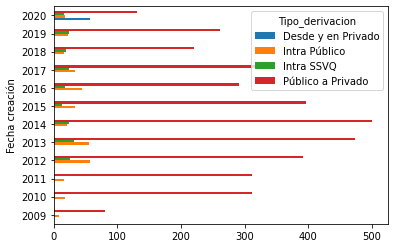

In [20]:
pd.crosstab(BD.Tipo_derivacion, BD['Fecha creación'].dt.year).T.plot(kind='barh')


In [21]:
BD['Fecha creación'].describe()

count                    4306
unique                   4200
top       2018-02-19 00:10:00
freq                        4
first     2009-05-21 08:28:00
last      2020-08-04 14:08:00
Name: Fecha creación, dtype: object

In [22]:
BD.Especialidad.value_counts()


ADULTO          3309
NEONATOLOGIA     765
PEDIATRIA        191
OBSTETRICO        16
Name: Especialidad, dtype: int64

In [23]:
ruta   = './Informe v1/textos/'
nombre = '00Derivacionesxespecialidad10a' + '.tab'
ruta+nombre
tabla  = open(str(ruta+nombre),'w')

Derivaciones = BD.loc[
    (BD['Fecha creación']>pd.to_datetime('2010-01-01')) &
    DIGAMOS_QUESI].copy()

A_ESCRIBIR = pd.crosstab(
    Derivaciones['Fecha creación'].dt.year,
    Derivaciones.Especialidad)[['ADULTO',  'NEONATOLOGIA',  'PEDIATRIA']]

print(A_ESCRIBIR.to_latex(bold_rows= True,
                    float_format="%.1f",
                    column_format = 'rcccccc',
                    multicolumn_format = 'c',
                    col_space=0.01),
      file=tabla)
tabla.close()
print(A_ESCRIBIR)

'./Informe v1/textos/00Derivacionesxespecialidad10a.tab'

Especialidad    ADULTO  NEONATOLOGIA  PEDIATRIA
Fecha creación                                 
2010               224            68          6
2011               208           104         17
2012               368            90         17
2013               466            66         28
2014               456            88          3
2015               359            66         19
2016               267            55         33
2017               296            54         35
2018               204            45          7
2019               219            66         23
2020               115            49          1


In [24]:
ruta   = './Informe v1/textos/'
nombre = '00Derivaciones_segunorigenydestino' + '.tab'
ruta+nombre
tabla  = open(str(ruta+nombre),'w')

Derivaciones = BD.loc[
    (BD.Especialidad == 'ADULTO') &
    DIGAMOS_QUESI].copy()

A_ESCRIBIR = pd.crosstab(
    Derivaciones['Fecha creación'].dt.year,
    Derivaciones.Tipo_derivacion)

print(A_ESCRIBIR.to_latex(bold_rows= True,
                    float_format="%.0f",
                    column_format = 'rcccccc',
                    multicolumn_format = 'c',
                    col_space=0.01,
                         na_rep = '-'),
      file=tabla)
tabla.close()
print(A_ESCRIBIR)

'./Informe v1/textos/00Derivaciones_segunorigenydestino.tab'

Tipo_derivacion  Intra Público  Intra SSVQ  Público a Privado
Fecha creación                                               
2009                         4           0                 64
2010                        11           1                212
2011                         6           1                201
2012                        44          23                301
2013                        44          31                391
2014                        17          24                415
2015                        22          14                323
2016                        18          16                233
2017                         6          22                268
2018                         6          18                180
2019                         9          19                191
2020                        17          14                 84


In [25]:
ruta   = './Informe v1/textos/'
nombre = '00Derivacionesxhospital2020' + '.tab'
ruta+nombre
tabla  = open(str(ruta+nombre),'w')

Derivaciones = BD.loc[
    (BD.Especialidad == 'ADULTO') &
    (BD['Fecha creación']>pd.to_datetime('2017-01-01') ) &
     DIGAMOS_QUESI
].copy()

dum = Derivaciones
agrupado = dum.groupby(
    [pd.Grouper(key='Fecha creación',freq = 'MS', closed='left'),
    dum.Origen])
A_ESCRIBIR = agrupado.id.count().unstack()[['H. Gustavo Fricke',
                                            'H. Quilpué',
                                            'H. San Martín de Quillota']]
# Sumo el mensual
A_ESCRIBIR['Total'] =A_ESCRIBIR.agg('sum', axis ='columns')

print(A_ESCRIBIR.to_latex(bold_rows= True,
                    float_format="%.0f",
                    column_format = 'rcccccc',
                    multicolumn_format = 'c',
                    col_space=0.01,
                         na_rep = '-'),
      file=tabla)
tabla.close()
print(A_ESCRIBIR)

'./Informe v1/textos/00Derivacionesxhospital2020.tab'

Origen          H. Gustavo Fricke  H. Quilpué  H. San Martín de Quillota  \
Fecha creación                                                             
2017-01-01                   12.0         1.0                        5.0   
2017-02-01                    6.0         3.0                        4.0   
2017-03-01                   11.0         2.0                        7.0   
2017-04-01                   15.0         3.0                        5.0   
2017-05-01                   12.0         1.0                        7.0   
2017-06-01                    2.0         3.0                       22.0   
2017-07-01                   17.0         6.0                       10.0   
2017-08-01                   14.0         5.0                       15.0   
2017-09-01                   15.0         9.0                        6.0   
2017-10-01                   16.0         5.0                       16.0   
2017-11-01                   10.0         3.0                       16.0   
2017-12-01  

In [26]:
ruta   = './Informe v1/textos/'
nombre = '00Derivacionesxhospital_detalle' + '.tab'
ruta+nombre
tabla  = open(str(ruta+nombre),'w')


Derivaciones = BD.loc[
    (BD.Especialidad == 'ADULTO') &
    (BD['Fecha creación']>pd.to_datetime('2017-01-01')) &
     DIGAMOS_QUESI
].copy()

dum = Derivaciones
agrupado = dum.groupby(
    [pd.Grouper(key='Fecha creación',freq = 'MS', closed='left'),
    'Tipo_derivacion', 'Origen'])
A_ESCRIBIR = agrupado.id.count().unstack()[[
    'H. Gustavo Fricke',
    'H. Quilpué',
    'H. San Martín de Quillota'
]]

A_ESCRIBIR = A_ESCRIBIR.unstack()#.drop('Desde y en Privado', axis=1, level=1)
# A_ESCRIBIR['Total'] =A_ESCRIBIR.agg('sum', axis ='columns')

print(A_ESCRIBIR.to_latex(bold_rows= True,
                    float_format="%.0f",
#                     column_format = 'rcccccc',
                    multicolumn_format = 'c',
                    col_space=0.01,
                         na_rep = '-'),
      file=tabla)
tabla.close()
print(A_ESCRIBIR)

'./Informe v1/textos/00Derivacionesxhospital_detalle.tab'

Origen          H. Gustavo Fricke                                 H. Quilpué  \
Tipo_derivacion     Intra Público Intra SSVQ Público a Privado Intra Público   
Fecha creación                                                                 
2017-01-01                    NaN        NaN              12.0           NaN   
2017-02-01                    NaN        NaN               6.0           1.0   
2017-03-01                    1.0        2.0               8.0           NaN   
2017-04-01                    NaN        NaN              15.0           NaN   
2017-05-01                    1.0        1.0              10.0           NaN   
2017-06-01                    NaN        NaN               2.0           NaN   
2017-07-01                    NaN        NaN              17.0           NaN   
2017-08-01                    NaN        1.0              13.0           NaN   
2017-09-01                    NaN        NaN              15.0           1.0   
2017-10-01                    NaN       

In [27]:
ruta   = './Informe v1/textos/'
nombre = '00Derivacionesmensual5a' + '.tab'
ruta+nombre
tabla  = open(str(ruta+nombre),'w')

Derivaciones = BD.loc[
    (BD.Especialidad == 'ADULTO') &
    (BD['Fecha creación']>pd.to_datetime('2015-01-01')) &
    (BD['Tipo_derivacion'] != 'Desde y en Privado')
].copy()
dum = Derivaciones
agrupado = dum.groupby([dum['Fecha creación'].dt.month, dum['Fecha creación'].dt.year,])

A_ESCRIBIR = agrupado.id.count().unstack()
print(A_ESCRIBIR.to_latex(bold_rows= True,
                    float_format="%.0f",
                    column_format = 'rcccccc',
                    multicolumn_format = 'c',
                    col_space=0.01,
                          index_names=False,
                          na_rep = '-'
                         ),
      file=tabla)
tabla.close()
print(A_ESCRIBIR)

'./Informe v1/textos/00Derivacionesmensual5a.tab'

Fecha creación  2015  2016  2017  2018  2019  2020
Fecha creación                                    
1               48.0  22.0  18.0  20.0  33.0  17.0
2               26.0  22.0  13.0  26.0  19.0  16.0
3               32.0  26.0  20.0  16.0  17.0  17.0
4               24.0  40.0  23.0  29.0  15.0   4.0
5               22.0  34.0  20.0  17.0  21.0  12.0
6               26.0  22.0  27.0  19.0  23.0  22.0
7               19.0  16.0  33.0  24.0  18.0  23.0
8               38.0  17.0  34.0   6.0  19.0   4.0
9               40.0  22.0  30.0  13.0  10.0   NaN
10              31.0  13.0  37.0  15.0  18.0   NaN
11              27.0  23.0  29.0  10.0   9.0   NaN
12              26.0  10.0  12.0   9.0  17.0   NaN


Text(0.5, 1.0, 'Cantidad de derivación por medio \n de UGCC desde el SSVQ')

Text(0.5, 0, 'Fecha de derivación')

Text(0, 0.5, 'Cantidad de derivaciones mensuales')

Guardado:./Informe v1/figuras/Derivaciones10_20.png


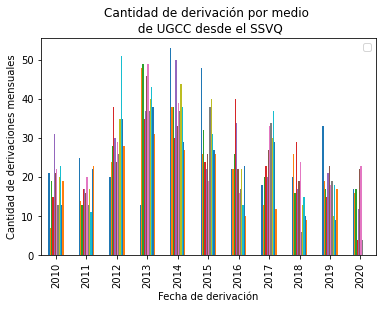

In [28]:
Derivaciones = BD.loc[
    (BD.Especialidad == 'ADULTO') &
    (BD['Fecha creación']>pd.to_datetime('2010-01-01')) &
    DIGAMOS_QUESI  # ojo con !=
].copy()

dum = Derivaciones
agrupado = dum.groupby([dum['Fecha creación'].dt.year, dum['Fecha creación'].dt.month])

agrupado.id.count().unstack().plot(kind='bar')
plt.legend('')
plt.title(
'Cantidad de derivación por medio \n \
de UGCC desde el SSVQ')
plt.xlabel('Fecha de derivación')
plt.ylabel('Cantidad de derivaciones mensuales')

guardar = True
nombre_archivo = 'Derivaciones10_20' + '.png'
ruta = './Informe v1/figuras/' +  nombre_archivo
if guardar == True:      
    print('Guardado:' + ruta)
    plt.savefig(ruta, bbox_inches='tight', dpi = 150)

In [29]:
meses = ['Ene', 'Feb', 'Mar', 'Abr', 'May',
        'Jun', 'Jul', 'Ago', 'Sep',
        'Oct', 'Nov', 'Dic']

Text(0.5, 1.0, 'Cantidad de derivación por medio \n de UGCC desde el SSVQ')

Text(0.5, 0, 'Fecha de derivación')

Text(0, 0.5, 'Cantidad de derivaciones mensuales')

([<matplotlib.axis.XTick at 0x7fd4f7849f28>,
 [Text(0, 0, 'Ene'),
  Text(0, 0, 'Feb'),
  Text(0, 0, 'Mar'),
  Text(0, 0, 'Abr'),
  Text(0, 0, 'May'),
  Text(0, 0, 'Jun'),
  Text(0, 0, 'Jul'),
  Text(0, 0, 'Ago'),
  Text(0, 0, 'Sep'),
  Text(0, 0, 'Oct'),
  Text(0, 0, 'Nov')])

Guardado:./Informe v1/figuras/Derivaciones17_20.png


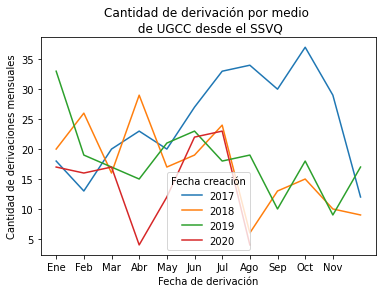

In [30]:
Derivaciones = BD.loc[
    (BD.Especialidad == 'ADULTO') &
    (BD['Fecha creación']>pd.to_datetime('2017-01-01')) &
    (BD['Tipo_derivacion'] != 'Desde y en Privado')
].copy()

dum = Derivaciones
agrupado = dum.groupby([dum['Fecha creación'].dt.month, dum['Fecha creación'].dt.year])

meses = ['Ene', 'Feb', 'Mar', 'Abr', 'May',
        'Jun', 'Jul', 'Ago', 'Sep',
        'Oct', 'Nov', 'Dic']

graf = agrupado.id.count().unstack()
graf.plot()
# plt.legend('')
plt.title(
'Cantidad de derivación por medio \n \
de UGCC desde el SSVQ')
plt.xlabel('Fecha de derivación')
plt.ylabel('Cantidad de derivaciones mensuales')
plt.xticks(np.arange(1,12,1),meses)

guardar = True
nombre_archivo = 'Derivaciones17_20' + '.png'
ruta = './Informe v1/figuras/' +  nombre_archivo
if guardar == True:      
    print('Guardado:' + ruta)
    plt.savefig(ruta, bbox_inches='tight', dpi = 150)

Text(0.5, 1.0, 'Cantidad de derivación por medio \n de UGCC desde el SSVQ año 2020')

Text(0.5, 0, 'Fecha de derivación \n en semanas')

Text(0, 0.5, 'Cantidad de derivaciones semanales')

([<matplotlib.axis.XTick at 0x7fd4f75a0ac8>,
 [Text(0, 0, 'Ene'),
  Text(0, 0, 'Feb'),
  Text(0, 0, 'Mar'),
  Text(0, 0, 'Abr'),
  Text(0, 0, 'May'),
  Text(0, 0, 'Jun'),
  Text(0, 0, 'Jul'),
  Text(0, 0, 'Ago')])

Guardado:./Informe v1/figuras/Derivaciones2020.png


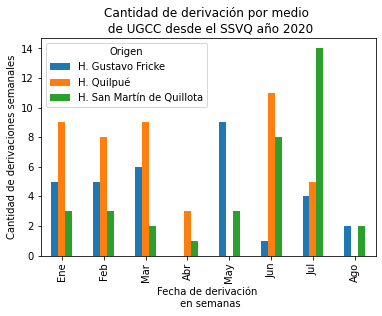

In [31]:
Derivaciones = BD.loc[
    (BD.Especialidad == 'ADULTO') &
    (BD['Fecha creación']>pd.to_datetime('2020-01-01')) &
    (BD['Tipo_derivacion'] != 'Desde y en Privado')
].copy()

dum = Derivaciones
agrupado = dum.groupby(
    [pd.Grouper(key='Fecha creación',freq = 'MS'),
    dum.Origen])

graf = agrupado.id.count().unstack()[['H. Gustavo Fricke',
                                            'H. Quilpué',
                                            'H. San Martín de Quillota']]
# graf
graf = graf.fillna(0)
graf.plot(kind='bar')
plt.title(
'Cantidad de derivación por medio \n \
de UGCC desde el SSVQ año 2020')
plt.xlabel('Fecha de derivación \n en semanas')
plt.ylabel('Cantidad de derivaciones semanales')
plt.xticks(np.arange(len(graf.index)),
           meses)

guardar = True
nombre_archivo = 'Derivaciones2020' + '.png'
ruta = './Informe v1/figuras/' +  nombre_archivo
if guardar == True:      
    print('Guardado:' + ruta)
    plt.savefig(ruta, bbox_inches='tight', dpi = 150)

## Derivaciones con domicilio de santiago

no existen

epidemiología de los pacientes

In [32]:
Derivaciones = BD.loc[
    (BD.Especialidad == 'ADULTO') &
    (BD['Tipo_derivacion'] != 'Desde y en Privado') &
    DIGAMOS_QUESI
].copy()

Derivaciones['Edad años'].describe()
Derivaciones['Edad años'].nsmallest()
Derivaciones['Edad años'].nlargest()
Derivaciones.groupby('Tipo_derivacion')['Edad años'].mean()

count    1235.000000
mean       59.638057
std        18.656739
min         0.000000
25%        48.000000
50%        64.000000
75%        74.000000
max        95.000000
Name: Edad años, dtype: float64

67       0.0
146     15.0
785     15.0
1513    15.0
1581    15.0
Name: Edad años, dtype: float64

2456    95.0
1023    94.0
1688    92.0
55      91.0
1691    91.0
Name: Edad años, dtype: float64

Tipo_derivacion
Intra Público        62.836538
Intra SSVQ           59.760870
Público a Privado    59.326267
Name: Edad años, dtype: float64

Text(0.5, 0.98, '')

Text(0.5, 1.0, 'Edad de los pacientes derivados')

Text(0.5, 0, 'Tipo de derivación')

Text(0, 0.5, 'Edad en años')

Guardado:./Informe v1/figuras/Edad_derivacion_historica.png


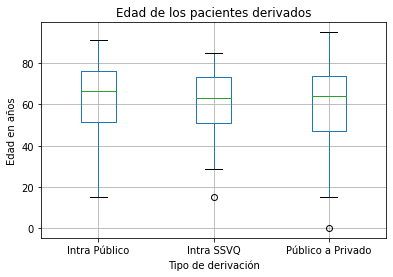

In [33]:
Derivaciones = BD.loc[
    (BD.Especialidad == 'ADULTO') &
    DIGAMOS_QUESI
].copy()

dum = Derivaciones.dropna(subset=['Edad años'])
dum.boxplot(column= ['Edad años'],
                       by='Tipo_derivacion')
plt.suptitle('')
plt.title('Edad de los pacientes derivados')
plt.xlabel('Tipo de derivación')
plt.ylabel('Edad en años')

guardar = True
nombre_archivo = 'Edad_derivacion_historica' + '.png'
ruta = './Informe v1/figuras/' +  nombre_archivo
if guardar == True:      
    print('Guardado:' + ruta)
    plt.savefig(ruta, bbox_inches='tight', dpi = 150)

Index(['id', 'Pestaña', 'Id Madre', 'Servicio Salud', 'Origen', 'Tipo Destino',
       'Destino', 'Tipo cama', 'Fecha creación', 'Fecha derivación exitosa',
       'Especialidad', 'Nombre Paciente', 'rut paciente', 'Nuevo RUT Paciente',
       'Edad días', 'Edad meses', 'Edad años', 'Diagnóstico', 'Responsable',
       'Rol', 'Riesgo', 'cambio riesgo', 'Convenio', 'Paciente crónico', 'GES',
       'Dias de Estada', 'Tramo Fonasa', 'Asistencia Ventricular',
       'Tipo compra', 'ECMO', 'Id anterior', 'Re-derivaciones', 'ID-RNacidos',
       'Contingencia', 'Cuenta GRD', 'Tipo_derivacion'],
      dtype='object')

count    2813.000000
mean        8.842161
std         7.779910
min         1.000000
25%         4.000000
50%         7.000000
75%        11.000000
max        49.000000
Name: Dias de Estada, dtype: float64

Público a Privado    2464
Intra Público         183
Intra SSVQ            166
Name: Tipo_derivacion, dtype: int64

F_onewayResult(statistic=5.886943234618892, pvalue=0.002809793051993036)

Text(0.5, 0.98, '')

Text(0.5, 1.0, 'Estadía de los pacientes derivados')

Text(0.5, 0, 'Tipo de derivación')

Text(0, 0.5, 'Días de estadía')

Guardado:./Informe v1/figuras/Estadia_derivacion_historica.png


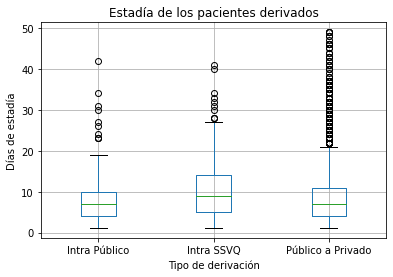

In [34]:
Derivaciones = BD.loc[
    (BD.Especialidad == 'ADULTO') &
    DIGAMOS_QUESI
].copy()

Derivaciones.columns

dum = Derivaciones.dropna(subset=['Dias de Estada'])
dum = dum.loc[(dum['Dias de Estada']<dum['Dias de Estada'].quantile(0.99)) &
              (dum['Dias de Estada']>0)
             ]

dum['Dias de Estada'].describe()
dum.Tipo_derivacion.value_counts()
stats.f_oneway(dum.loc[dum['Tipo_derivacion'] == 'Público a Privado']['Dias de Estada'],
               dum.loc[dum['Tipo_derivacion'] == 'Intra Público']['Dias de Estada'],
               dum.loc[dum['Tipo_derivacion'] == 'Intra SSVQ']['Dias de Estada'])


dum.boxplot(column= ['Dias de Estada'],
                       by='Tipo_derivacion')
plt.suptitle('')
plt.title('Estadía de los pacientes derivados')
plt.xlabel('Tipo de derivación')
plt.ylabel('Días de estadía')

guardar = True
nombre_archivo = 'Estadia_derivacion_historica' + '.png'
ruta = './Informe v1/figuras/' +  nombre_archivo
if guardar == True:      
    print('Guardado:' + ruta)
    plt.savefig(ruta, bbox_inches='tight', dpi = 150)